In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
classes = [0, 4, 9]
branch_defs = [
    ((0, 4, 9), 650, 1000),
    ((0,), 0, 650),
    ((4, 9), 550, 650),
    ((4,), 0, 550),
    ((9,), 0, 550)
]

# classes = [0]
# branch_defs = [
#     ((0,), 0, 1000)
# ]

dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [4]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Create the model

In [5]:
# Create the diffuser and model
diffuser = discrete_diffusers.GaussianDiffuser(1e-4, 1e-5, input_shape)

t_limit = 1000

model = image_unet.MultitaskMNISTUNetTimeConcat(
    len(branch_defs), t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/test_discrete"

import model.train_discrete_model as train_discrete_model  # Import this AFTER setting environment

### Show the forward-diffusion process

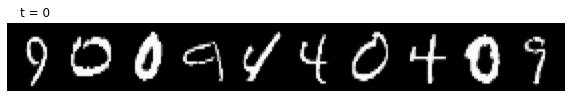

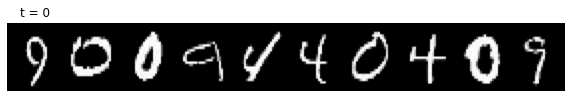

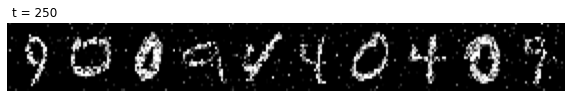

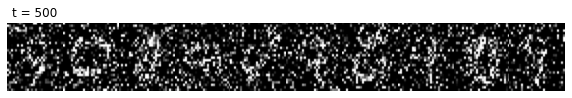

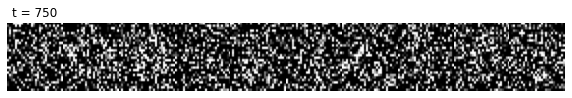

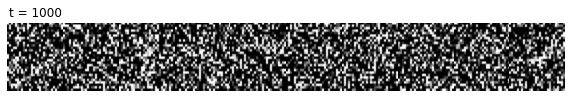

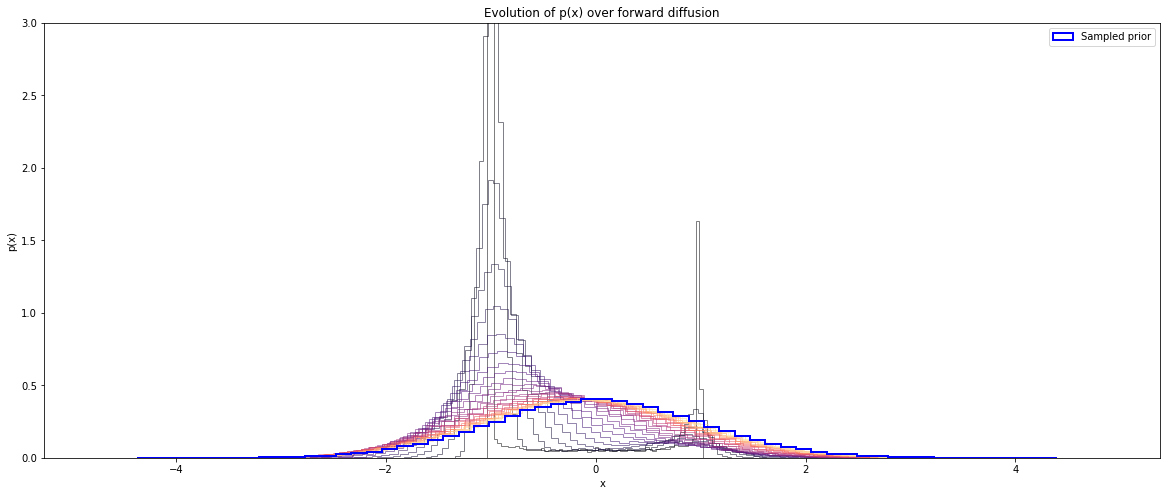

In [6]:
# Show some images after running the diffuser forward for different times
time_steps = 4

x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()

plot_mnist_digits(x0, grid_size=(10, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.arange(0, t_limit + 1, t_limit // time_steps):
    xt, score = diffuser.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_mnist_digits(xt.cpu().numpy(), grid_size=(10, 1), title=("t = %d" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = diffuser.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = diffuser.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward diffusion")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [7]:
train_discrete_model.train_ex.run(
    "train_model",
    config_updates={
        "model": model,
        "diffuser": diffuser,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 30,
        "learning_rate": 0.001,
        "t_limit": t_limit
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "diffuser"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_model'
INFO - train - Started run with ID "2"
Loss: 194.80: 100%|████████████████████████████████████████| 139/139 [01:11<00:00,  1.95it/s]


Epoch 1 average Loss: 430.83


Loss: 115.65: 100%|████████████████████████████████████████| 139/139 [00:16<00:00,  8.40it/s]


Epoch 2 average Loss: 144.81


Loss: 114.17: 100%|████████████████████████████████████████| 139/139 [00:12<00:00, 10.91it/s]


Epoch 3 average Loss: 117.23


Loss: 83.74: 100%|█████████████████████████████████████████| 139/139 [00:12<00:00, 10.91it/s]


Epoch 4 average Loss: 94.81


Loss: 69.81: 100%|█████████████████████████████████████████| 139/139 [00:12<00:00, 10.90it/s]


Epoch 5 average Loss: 86.29


Loss: 88.16: 100%|█████████████████████████████████████████| 139/139 [00:12<00:00, 10.89it/s]


Epoch 6 average Loss: 81.31


Loss: 64.13: 100%|█████████████████████████████████████████| 139/139 [00:12<00:00, 10.87it/s]


Epoch 7 average Loss: 72.18


Loss: 61.27: 100%|█████████████████████████████████████████| 139/139 [00:14<00:00,  9.88it/s]


Epoch 8 average Loss: 66.89


Loss: 87.30: 100%|█████████████████████████████████████████| 139/139 [00:12<00:00, 10.93it/s]


Epoch 9 average Loss: 62.17


Loss: 79.76: 100%|█████████████████████████████████████████| 139/139 [00:13<00:00, 10.69it/s]


Epoch 10 average Loss: 60.59


Loss: 59.97: 100%|█████████████████████████████████████████| 139/139 [00:16<00:00,  8.23it/s]


Epoch 11 average Loss: 58.64


Loss: 54.29: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.63it/s]


Epoch 12 average Loss: 55.96


Loss: 55.96: 100%|█████████████████████████████████████████| 139/139 [00:17<00:00,  8.01it/s]


Epoch 13 average Loss: 54.61


Loss: 49.61: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.72it/s]


Epoch 14 average Loss: 52.93


Loss: 62.78: 100%|█████████████████████████████████████████| 139/139 [00:17<00:00,  7.75it/s]


Epoch 15 average Loss: 51.42


Loss: 47.81: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.42it/s]


Epoch 16 average Loss: 50.96


Loss: 40.12: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.52it/s]


Epoch 17 average Loss: 49.03


Loss: 47.28: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.36it/s]


Epoch 18 average Loss: 48.22


Loss: 40.99: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.55it/s]


Epoch 19 average Loss: 47.31


Loss: 43.93: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.55it/s]


Epoch 20 average Loss: 47.15


Loss: 39.88: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.67it/s]


Epoch 21 average Loss: 46.13


Loss: 38.60: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.71it/s]


Epoch 22 average Loss: 46.33


Loss: 37.92: 100%|█████████████████████████████████████████| 139/139 [00:17<00:00,  7.89it/s]


Epoch 23 average Loss: 44.54


Loss: 40.43: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.48it/s]


Epoch 24 average Loss: 44.07


Loss: 37.28: 100%|█████████████████████████████████████████| 139/139 [00:17<00:00,  7.77it/s]


Epoch 25 average Loss: 44.21


Loss: 50.90: 100%|█████████████████████████████████████████| 139/139 [00:17<00:00,  7.79it/s]


Epoch 26 average Loss: 44.65


Loss: 33.41: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.65it/s]


Epoch 27 average Loss: 43.25


Loss: 32.00: 100%|█████████████████████████████████████████| 139/139 [00:18<00:00,  7.59it/s]


Epoch 28 average Loss: 42.18


Loss: 45.18: 100%|█████████████████████████████████████████| 139/139 [00:17<00:00,  7.91it/s]


Epoch 29 average Loss: 42.35


Loss: 41.54: 100%|█████████████████████████████████████████| 139/139 [00:17<00:00,  7.97it/s]
INFO - train - Completed after 0:09:15


Epoch 30 average Loss: 41.97


### Show generated digits

Sampling class: 0


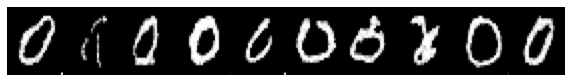

Sampling class: 4


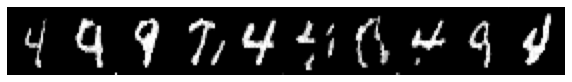

Sampling class: 9


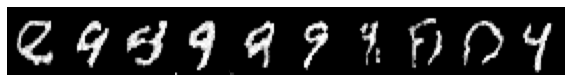

In [8]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_discrete_samples(
        model, diffuser, class_to_sample, class_time_to_branch_tensor,
        t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)

**Intermediate states**

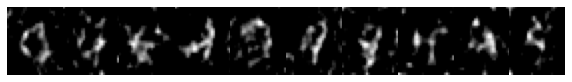

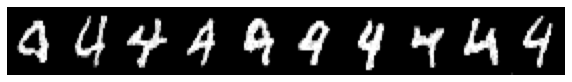

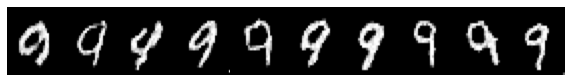

In [12]:
samples_49 = generate.generate_discrete_samples(
    model, diffuser, 4, class_time_to_branch_tensor, t_start=550,
    t_limit=t_limit
).cpu().numpy()
samples_4 = generate.generate_discrete_samples(
    model, diffuser, 4, class_time_to_branch_tensor, t_limit=550,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()
samples_9 = generate.generate_discrete_samples(
    model, diffuser, 9, class_time_to_branch_tensor, t_limit=550,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()

smoothed_samples_49 = np.empty_like(samples_49)
for i in range(len(samples_49)):
    smoothed_samples_49[i, 0] = scipy.ndimage.gaussian_filter(samples_49[i, 0], sigma=1)
    
plot_mnist_digits(smoothed_samples_49)
plot_mnist_digits(samples_4)
plot_mnist_digits(samples_9)

**Diffusing from one class to another**

/local/53588175/ipykernel_29414/3319062331.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)


4 to 9


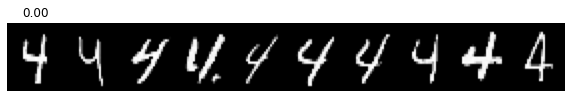

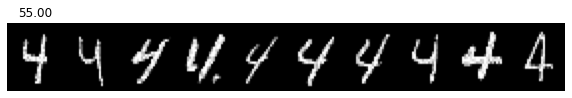

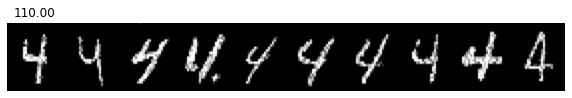

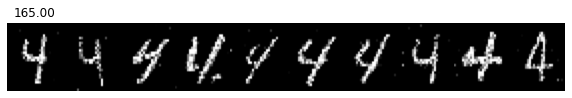

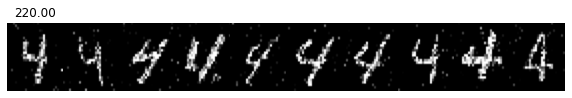

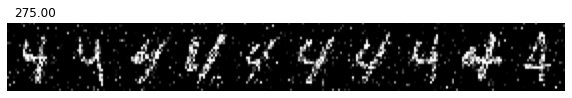

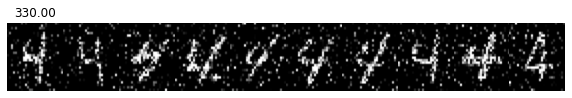

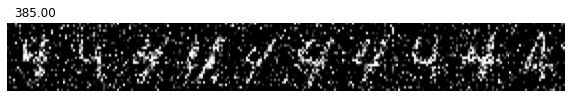

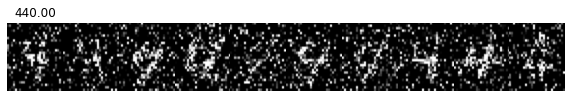

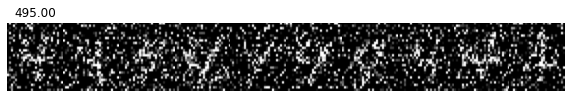

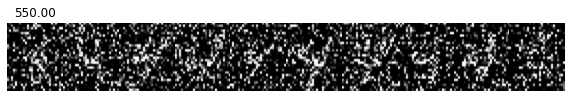

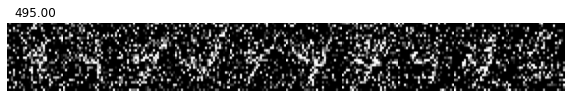

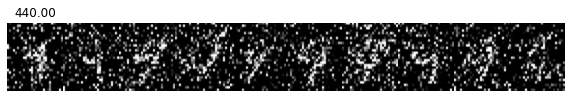

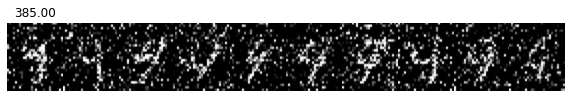

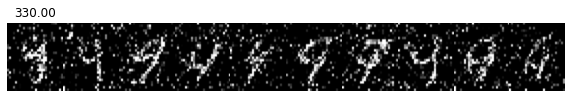

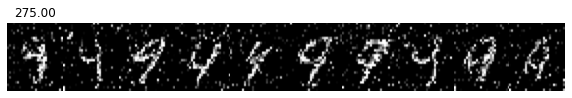

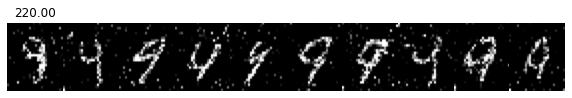

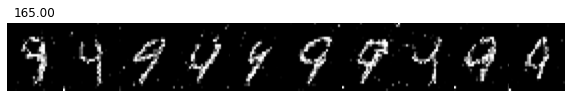

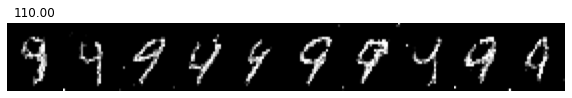

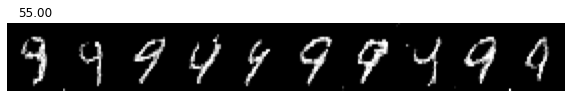

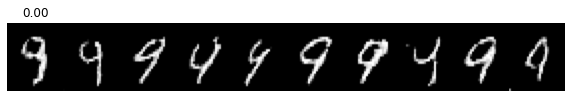

9 to 4


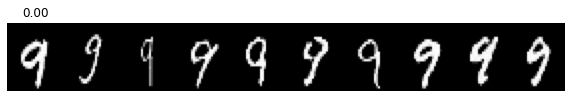

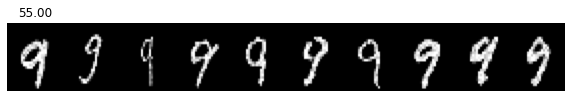

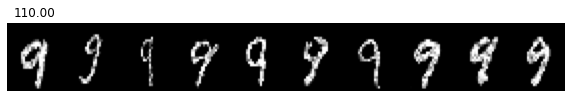

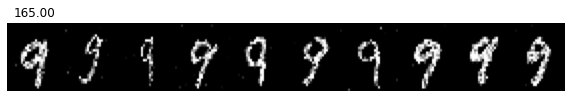

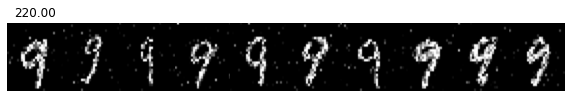

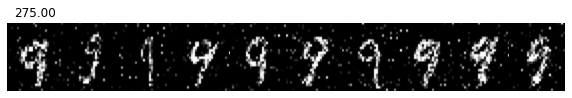

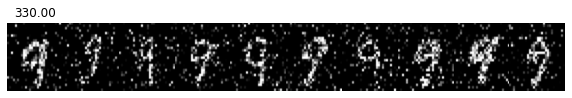

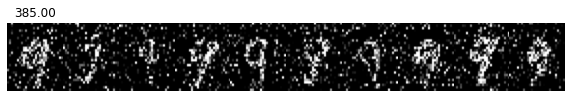

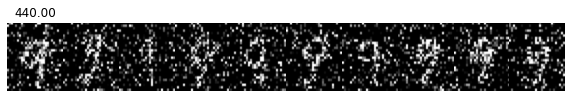

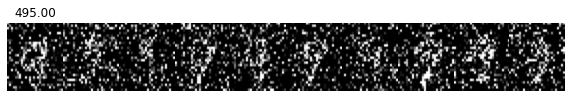

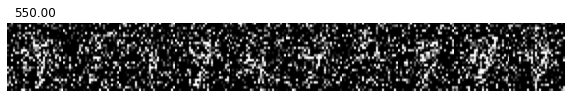

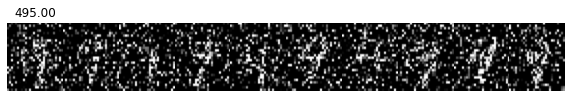

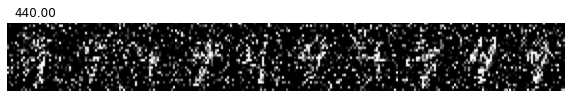

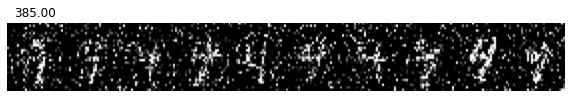

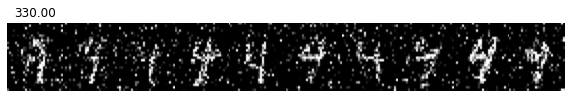

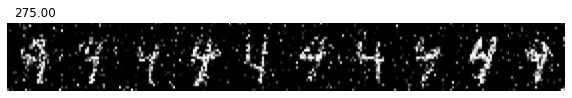

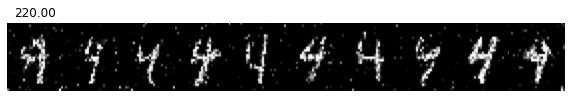

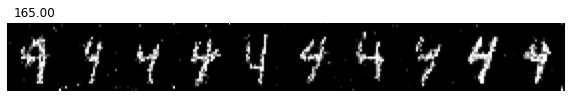

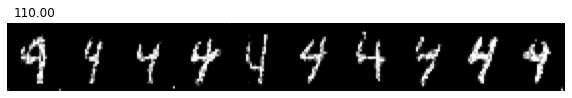

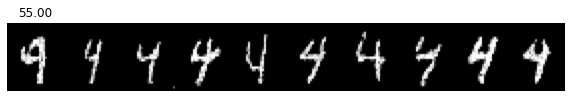

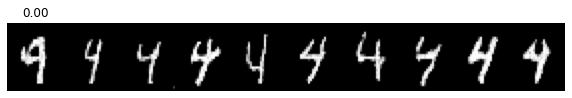

In [11]:
orig_4 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 4)[0], size=32, replace=False)
])
orig_9 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 9)[0], size=32, replace=False)
])

time_steps = 10
all_t = np.arange(0, 550 + 1, 550 // time_steps)
forward_4_to_9 = np.empty((len(all_t),) + orig_4.shape)
backward_4_to_9 = np.empty((len(all_t) - 1,) + orig_4.shape)
forward_9_to_4 = np.empty((len(all_t),) + orig_4.shape)
backward_9_to_4 = np.empty((len(all_t) - 1,) + orig_4.shape)
orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)
for t_i, t in enumerate(all_t):
    forward_4_to_9[t_i] = diffuser.forward(
        orig_4_tens, torch.ones(len(orig_4_tens)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_9_to_4[t_i] = diffuser.forward(
        orig_9_tens, torch.ones(len(orig_9_tens)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_4_to_9 = torch.tensor(forward_4_to_9[-1]).to(DEVICE).float()
last_9_to_4 = torch.tensor(forward_9_to_4[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_4_to_9 = generate.generate_discrete_samples(
        model, diffuser, 9, class_time_to_branch_tensor,
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_4.shape[0], initial_samples=last_4_to_9
    )
    backward_4_to_9[t_i] = last_4_to_9.cpu().numpy()
    
    last_9_to_4 = generate.generate_discrete_samples(
        model, diffuser, 4, class_time_to_branch_tensor,
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_9.shape[0], initial_samples=last_9_to_4
    )
    backward_9_to_4[t_i] = last_9_to_4.cpu().numpy()
    
print("4 to 9")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_4_to_9[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_4_to_9[t_i], title=("%.2f" % t))

print("9 to 4")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_9_to_4[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_9_to_4[t_i], title=("%.2f" % t))